In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torchvision import transforms
from torch.utils.data import Dataset

#plot
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np 


In [2]:
import sys
sys.path.append('/cephyr/users/olebal/Alvis/lora_ensembles/equivariant-posteriors')

In [16]:
import numpy as np
import dill as pickle

def read_res_from_dill(path):  
    with open(path, 'rb') as fp:
        res = pickle.load(fp)   
    return res

def calculate_mean_softmax_probs (softmax_probs_ensemble: torch.Tensor) -> torch.Tensor:

    mean_softmax_probs = torch.mean(softmax_probs_ensemble, dim=0)
    return mean_softmax_probs


def calculate_entropy_ens(
    softmax_probs_ensemble: torch.Tensor, 
    dim: int = -1, 
    eps: float = 1e-9
) -> torch.Tensor:

    softmax_probs = calculate_mean_softmax_probs(softmax_probs_ensemble)
    entropy = calculate_entropy(softmax_probs, dim, eps)

    return entropy

def calculate_entropy(
    softmax_probs: torch.Tensor, 
    dim: int = -1, 
    eps: float = 1e-9
) -> torch.Tensor:
    entropy = -torch.sum(softmax_probs * torch.log(softmax_probs + eps), dim=dim)
    return entropy

def calculate_outclass_probs(
    softmax_probs_ensemble: torch.Tensor
) -> torch.Tensor:

    mean_softmax_probs = calculate_mean_softmax_probs(softmax_probs_ensemble)
    print(f"Outclass index: {mean_softmax_probs.shape[-1]}")
    outclass_mean_softmax_probs = mean_softmax_probs[:, -1]

    return outclass_mean_softmax_probs

def calculate_mutual_information_ens(
    softmax_probs_ensemble: torch.Tensor
) -> torch.Tensor:

    entropy_of_the_mean_ens_prob = calculate_entropy_ens(softmax_probs_ensemble)
    mean_ens_entropy = torch.mean(calculate_entropy(softmax_probs_ensemble), dim=0)
    
    mutual_information = entropy_of_the_mean_ens_prob - mean_ens_entropy

    return mutual_information

In [43]:
import os
path_dirs = []
path_files = []
names = []

epochs = [1, 3, 6]

path_dirs.append(f"/mimer/NOBACKUP/groups/snic2022-22-448/lora_ensembles/ens_llm_lora_eval_3/train_commonsense_qa/ens/EPOCH/dataset_commonsense_qa")
path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_8_dr_0_rl2_0_rl2_1.dill")
names.append("Lora Ens (M=5) \n (csqa)")

path_dirs.append(f"/mimer/NOBACKUP/groups/snic2022-22-448/lora_ensembles/ens_llm_lora_eval_3/train_commonsense_qa/ens/EPOCH/dataset_mmlu_stem")
path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_8_dr_0_rl2_0_rl2_1.dill")
names.append("Lora Ens (M=5) \n (mmlu_stem)")

path_dirs.append(f"/mimer/NOBACKUP/groups/snic2022-22-448/lora_ensembles/ens_llm_lora_eval_3/train_commonsense_qa/ens/EPOCH/dataset_mmlu_ss")
path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_8_dr_0_rl2_0_rl2_1.dill")
names.append("Lora Ens (M=5) \n (mmlu_ss)")


In [44]:
entropy_res_dic = {}
mutual_info_res_dic = {}

for epoch in epochs:
    for index, path_file in enumerate(path_files):
        name = names[index]+"_"+str(epoch)
        accumulated_ens_probs = []
        for member_id in range(5):
            full_path_file = os.path.join(path_dirs[index].replace("EPOCH", str(epoch)), "member_"+str(member_id), path_file)
            res = read_res_from_dill(full_path_file)
            accumulated_ens_probs.append(res['softmax_probs'].unsqueeze(0))
        targets = res['targets']
        
        
        softprobs = torch.cat(accumulated_ens_probs)
        
        outclass_probs = calculate_outclass_probs(softprobs)
        #print(torch.max(outclass_probs))
        #print(f"{outclass_probs[outclass_probs>0.05].shape[0]}/{outclass_probs.shape[0]}")
        

        #softprobs = softprobs[:, outclass_probs>0.05, :]
        if softprobs.shape[1]>0:
            #targets = targets[outclass_probs>0.05]
            #print(softprobs.shape)

            mean_softprobs = calculate_mean_softmax_probs(softprobs)
            softprobs_correct = softprobs[:, torch.argmax(mean_softprobs, dim=-1)==targets] 
            softprobs_wrong = softprobs[:, torch.argmax(mean_softprobs, dim=-1)!=targets] 

            entropies = calculate_entropy_ens(softprobs_correct)
            mutual_info = calculate_mutual_information_ens(softprobs_correct)

            entropy_res_dic[name+"_correct"] = entropies
            mutual_info_res_dic[name+"_correct"] = mutual_info

            entropies = calculate_entropy_ens(softprobs_wrong)
            mutual_info = calculate_mutual_information_ens(softprobs_wrong)

            entropy_res_dic[name+"_wrong"] = entropies
            mutual_info_res_dic[name+"_wrong"] = mutual_info

Outclass index: 6
Outclass index: 6
Outclass index: 6
Outclass index: 6
Outclass index: 6
Outclass index: 6
Outclass index: 6
Outclass index: 6
Outclass index: 6


In [45]:
value = 0
print(torch.argmax(mean_softprobs, dim=-1)[torch.argmax(mean_softprobs, dim=-1)==value].shape)
value = 1
print(torch.argmax(mean_softprobs, dim=-1)[torch.argmax(mean_softprobs, dim=-1)==value].shape)
value = 2
print(torch.argmax(mean_softprobs, dim=-1)[torch.argmax(mean_softprobs, dim=-1)==value].shape)
value = 3
print(torch.argmax(mean_softprobs, dim=-1)[torch.argmax(mean_softprobs, dim=-1)==value].shape)
value = 4
print(torch.argmax(mean_softprobs, dim=-1)[torch.argmax(mean_softprobs, dim=-1)==value].shape)

torch.Size([650])
torch.Size([782])
torch.Size([726])
torch.Size([788])
torch.Size([0])


In [46]:
names

['Lora Ens (M=5) \n (csqa)',
 'Lora Ens (M=5) \n (mmlu_stem)',
 'Lora Ens (M=5) \n (mmlu_ss)']

In [47]:
print(entropy_res_dic.keys())

dict_keys(['Lora Ens (M=5) \n (csqa)_1_correct', 'Lora Ens (M=5) \n (csqa)_1_wrong', 'Lora Ens (M=5) \n (mmlu_stem)_1_correct', 'Lora Ens (M=5) \n (mmlu_stem)_1_wrong', 'Lora Ens (M=5) \n (mmlu_ss)_1_correct', 'Lora Ens (M=5) \n (mmlu_ss)_1_wrong', 'Lora Ens (M=5) \n (csqa)_3_correct', 'Lora Ens (M=5) \n (csqa)_3_wrong', 'Lora Ens (M=5) \n (mmlu_stem)_3_correct', 'Lora Ens (M=5) \n (mmlu_stem)_3_wrong', 'Lora Ens (M=5) \n (mmlu_ss)_3_correct', 'Lora Ens (M=5) \n (mmlu_ss)_3_wrong', 'Lora Ens (M=5) \n (csqa)_6_correct', 'Lora Ens (M=5) \n (csqa)_6_wrong', 'Lora Ens (M=5) \n (mmlu_stem)_6_correct', 'Lora Ens (M=5) \n (mmlu_stem)_6_wrong', 'Lora Ens (M=5) \n (mmlu_ss)_6_correct', 'Lora Ens (M=5) \n (mmlu_ss)_6_wrong'])


--------------------------
Name: Lora Ens (M=5) 
 (csqa)_1_correct
Average Mutual Information at epoch 1:  0.006505073048174381
--------------------------
Name: Lora Ens (M=5) 
 (csqa)_1_wrong
Average Mutual Information at epoch 1:  0.01545005664229393
--------------------------
Name: Lora Ens (M=5) 
 (csqa)_1_wrong
Average Mutual Information at epoch 1:  0.01545005664229393
--------------------------
Name: Lora Ens (M=5) 
 (csqa)_3_correct
Average Mutual Information at epoch 3:  0.011012316681444645
--------------------------
Name: Lora Ens (M=5) 
 (csqa)_3_wrong
Average Mutual Information at epoch 3:  0.027813738211989403
--------------------------
Name: Lora Ens (M=5) 
 (csqa)_6_correct
Average Mutual Information at epoch 6:  0.0348982959985733
--------------------------
Name: Lora Ens (M=5) 
 (csqa)_6_wrong
Average Mutual Information at epoch 6:  0.11586515605449677


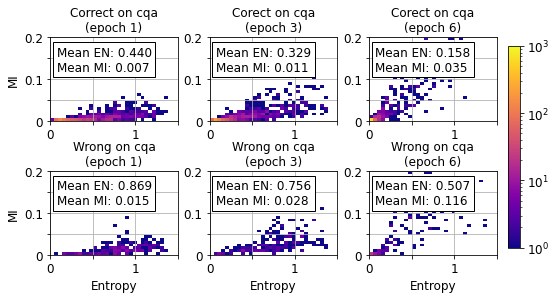

In [48]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Assuming your data is something like this (replace with your actual data)

# Create a figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(8, 4))
classes = 4
x_range = (0, np.log(classes))  
y_range = (0, 0.2)  

xtext = 0.05
ytext = 0.6

SMALL_SIZE = 12
FONTSIZE = 12
alpha = 1


# Define the range for the color scale
vmin, vmax = 1, 1000  # Example values, adjust as needed

# Create a LogNorm object with your desired scale
log_norm = colors.LogNorm(vmin=vmin, vmax=vmax)

names_index = 0
n_bins = 30
cmap = 'plasma'

# 2D histogram for Dataset 1
ax = axs[0][0]
epoch = epochs[0]
name = names[0]+f"_{epoch}_correct"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=n_bins, cmap=cmap,norm=log_norm, range=[x_range, y_range])
msg = f"Mean EN: {np.mean(x1):.3f}\nMean MI: {np.mean(y1):.3f}"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))

ax.set_title(f'Correct on cqa\n(epoch {epoch})', fontsize=SMALL_SIZE)
ax.set_ylabel('MI', fontsize=SMALL_SIZE)

print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")


# 2D histogram for Dataset 1
ax = axs[1][0]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[0]
name = names[0]+f"_{epoch}_wrong"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=n_bins, cmap=cmap,norm=log_norm, range=[x_range, y_range])
msg = f"Mean EN: {np.mean(x1):.3f}\nMean MI: {np.mean(y1):.3f}"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))

ax.set_title(f'Wrong on cqa\n(epoch {epoch})', fontsize=SMALL_SIZE)
ax.set_ylabel('MI', fontsize=SMALL_SIZE)
ax.set_xlabel("Entropy", fontsize=SMALL_SIZE)
print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")
print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")


# 2D histogram for Dataset 1
ax = axs[0][1]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[1]
name = names[0]+f"_{epoch}_correct"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=n_bins, cmap=cmap,norm=log_norm, range=[x_range, y_range])

msg = f"Mean EN: {np.mean(x1):.3f}\nMean MI: {np.mean(y1):.3f}"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))

ax.set_title(f'Corect on cqa\n(epoch {epoch})', fontsize=SMALL_SIZE)
#ax.set_ylabel('MI', fontsize=SMALL_SIZE)

print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")


# 2D histogram for Dataset 1
ax = axs[1][1]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[1]
name = names[0]+f"_{epoch}_wrong"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=n_bins, cmap=cmap,norm=log_norm, range=[x_range, y_range])
msg = f"Mean EN: {np.mean(x1):.3f}\nMean MI: {np.mean(y1):.3f}"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))
ax.set_xlabel("Entropy", fontsize=SMALL_SIZE)
ax.set_title(f'Wrong on cqa\n(epoch {epoch})', fontsize=SMALL_SIZE)
#ax.set_ylabel('MI', fontsize=SMALL_SIZE)

print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")


# 2D histogram for Dataset 1
ax = axs[0][2]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[2]
name = names[0]+f"_{epoch}_correct"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=n_bins, cmap=cmap,norm=log_norm, range=[x_range, y_range])
msg = f"Mean EN: {np.mean(x1):.3f}\nMean MI: {np.mean(y1):.3f}"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))

ax.set_title(f'Corect on cqa\n(epoch {epoch})', fontsize=SMALL_SIZE)
#ax.set_ylabel('MI', fontsize=SMALL_SIZE)

print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")



# 2D histogram for Dataset 1
ax = axs[1][2]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[2]
name = names[0]+f"_{epoch}_wrong"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=n_bins, cmap=cmap,norm=log_norm, range=[x_range, y_range])
msg = f"Mean EN: {np.mean(x1):.3f}\nMean MI: {np.mean(y1):.3f}"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))

ax.set_title(f'Wrong on cqa\n(epoch {epoch})', fontsize=SMALL_SIZE)
#ax.set_ylabel('MI', fontsize=SMALL_SIZE)
ax.set_xlabel("Entropy", fontsize=SMALL_SIZE)


print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")


# Create a color bar
#cbar = fig.colorbar(image1, ax=axs.ravel().tolist(), orientation='vertical')
#cbar.set_label('Color Bar Label')

for i in range(len(epochs)):
    for j in range(2):
        ax = axs[j][i]
        
        ax.set_xticks([0, 0.5, 1, 1.5])
        ax.set_xticklabels(['0', '', '1', ''], fontsize=SMALL_SIZE)
        ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
        ax.set_yticklabels(['0', '', '0.1', '', "0.2"], fontsize=SMALL_SIZE)
        
        ax.grid(b=True)
        
# Create a color bar
#cbar = fig.colorbar(image1, ax=axs.ravel().tolist(), orientation='vertical')
#cbar.set_label('Color Bar Label')

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # x-position, y-position, width, height
cbar = fig.colorbar(image1, ax=axs.ravel().tolist(), orientation='vertical', cax=cbar_ax)
cbar.ax.tick_params(labelsize=SMALL_SIZE)


plt.subplots_adjust(wspace=0.25, hspace=0.6)
plt.savefig('cqa_uncertainty.pdf', format='pdf', bbox_inches='tight')



--------------------------
Name: Lora Ens (M=5) 
 (mmlu_stem)_1_correct
Average Mutual Information at epoch 1:  0.004976523574441671
--------------------------
Name: Lora Ens (M=5) 
 (mmlu_stem)_1_wrong
Average Mutual Information at epoch 1:  0.00560635095462203
--------------------------
Name: Lora Ens (M=5) 
 (mmlu_stem)_1_wrong
Average Mutual Information at epoch 1:  0.00560635095462203
--------------------------
Name: Lora Ens (M=5) 
 (mmlu_stem)_3_correct
Average Mutual Information at epoch 3:  0.012661074288189411
--------------------------
Name: Lora Ens (M=5) 
 (mmlu_stem)_3_wrong
Average Mutual Information at epoch 3:  0.016682349145412445
--------------------------
Name: Lora Ens (M=5) 
 (mmlu_stem)_6_correct
Average Mutual Information at epoch 6:  0.03795016556978226
--------------------------
Name: Lora Ens (M=5) 
 (mmlu_stem)_6_wrong
Average Mutual Information at epoch 6:  0.05256083607673645
--------------------------
Name: Lora Ens (M=5) 
 (mmlu_ss)_1_correct
Average Mut

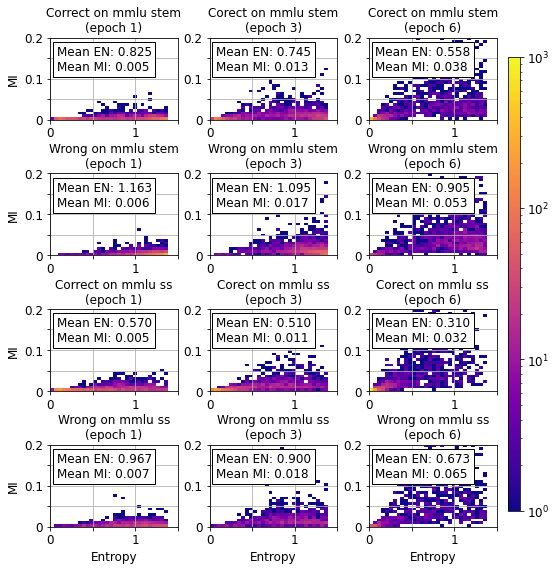

In [49]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Assuming your data is something like this (replace with your actual data)

# Create a figure with subplots
fig, axs = plt.subplots(4, 3, figsize=(8, 9))
classes = 4
x_range = (0, np.log(classes))  
y_range = (0, 0.2)  

xtext = 0.05
ytext = 0.6

SMALL_SIZE = 12
FONTSIZE = 12
alpha = 1


# Define the range for the color scale
vmin, vmax = 1, 1000  # Example values, adjust as needed

# Create a LogNorm object with your desired scale
log_norm = colors.LogNorm(vmin=vmin, vmax=vmax)

names_index = 1
n_bins = 30
cmap = 'plasma'

# 2D histogram for Dataset 1
ax = axs[0][0]
epoch = epochs[0]
name = names[names_index]+f"_{epoch}_correct"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=n_bins, cmap=cmap,norm=log_norm, range=[x_range, y_range])
msg = f"Mean EN: {np.mean(x1):.3f}\nMean MI: {np.mean(y1):.3f}"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))

ax.set_title(f'Correct on mmlu stem\n(epoch {epoch})', fontsize=SMALL_SIZE)
ax.set_ylabel('MI', fontsize=SMALL_SIZE)

print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")


# 2D histogram for Dataset 1
ax = axs[1][0]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[0]
name = names[names_index]+f"_{epoch}_wrong"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=n_bins, cmap=cmap,norm=log_norm, range=[x_range, y_range])
msg = f"Mean EN: {np.mean(x1):.3f}\nMean MI: {np.mean(y1):.3f}"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))

ax.set_title(f'Wrong on mmlu stem\n(epoch {epoch})', fontsize=SMALL_SIZE)
ax.set_ylabel('MI', fontsize=SMALL_SIZE)
print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")
print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")


# 2D histogram for Dataset 1
ax = axs[0][1]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[1]
name = names[names_index]+f"_{epoch}_correct"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=n_bins, cmap=cmap,norm=log_norm, range=[x_range, y_range])

msg = f"Mean EN: {np.mean(x1):.3f}\nMean MI: {np.mean(y1):.3f}"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))

ax.set_title(f'Corect on mmlu stem\n(epoch {epoch})', fontsize=SMALL_SIZE)
#ax.set_ylabel('MI', fontsize=SMALL_SIZE)

print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")


# 2D histogram for Dataset 1
ax = axs[1][1]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[1]
name = names[names_index]+f"_{epoch}_wrong"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=n_bins, cmap=cmap,norm=log_norm, range=[x_range, y_range])
msg = f"Mean EN: {np.mean(x1):.3f}\nMean MI: {np.mean(y1):.3f}"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))
ax.set_title(f'Wrong on mmlu stem\n(epoch {epoch})', fontsize=SMALL_SIZE)
#ax.set_ylabel('MI', fontsize=SMALL_SIZE)

print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")


# 2D histogram for Dataset 1
ax = axs[0][2]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[2]
name = names[names_index]+f"_{epoch}_correct"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=n_bins, cmap=cmap,norm=log_norm, range=[x_range, y_range])
msg = f"Mean EN: {np.mean(x1):.3f}\nMean MI: {np.mean(y1):.3f}"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))

ax.set_title(f'Corect on mmlu stem\n(epoch {epoch})', fontsize=SMALL_SIZE)
#ax.set_ylabel('MI', fontsize=SMALL_SIZE)

print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")



# 2D histogram for Dataset 1
ax = axs[1][2]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[2]
name = names[names_index]+f"_{epoch}_wrong"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=n_bins, cmap=cmap,norm=log_norm, range=[x_range, y_range])
msg = f"Mean EN: {np.mean(x1):.3f}\nMean MI: {np.mean(y1):.3f}"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))

ax.set_title(f'Wrong on mmlu stem\n(epoch {epoch})', fontsize=SMALL_SIZE)
#ax.set_ylabel('MI', fontsize=SMALL_SIZE)



print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")


###########################################################################
############################################################################
names_index = 2
# 2D histogram for Dataset 1
ax = axs[2][0]
epoch = epochs[0]
name = names[names_index]+f"_{epoch}_correct"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=n_bins, cmap=cmap,norm=log_norm, range=[x_range, y_range])
msg = f"Mean EN: {np.mean(x1):.3f}\nMean MI: {np.mean(y1):.3f}"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))

ax.set_title(f'Correct on mmlu ss\n(epoch {epoch})', fontsize=SMALL_SIZE)
ax.set_ylabel('MI', fontsize=SMALL_SIZE)

print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")


# 2D histogram for Dataset 1
ax = axs[3][0]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[0]
name = names[names_index]+f"_{epoch}_wrong"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=n_bins, cmap=cmap,norm=log_norm, range=[x_range, y_range])
msg = f"Mean EN: {np.mean(x1):.3f}\nMean MI: {np.mean(y1):.3f}"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))

ax.set_title(f'Wrong on mmlu ss\n(epoch {epoch})', fontsize=SMALL_SIZE)
ax.set_ylabel('MI', fontsize=SMALL_SIZE)
ax.set_xlabel("Entropy", fontsize=SMALL_SIZE)
print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")
print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")


# 2D histogram for Dataset 1
ax = axs[2][1]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[1]
name = names[names_index]+f"_{epoch}_correct"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=n_bins, cmap=cmap,norm=log_norm, range=[x_range, y_range])

msg = f"Mean EN: {np.mean(x1):.3f}\nMean MI: {np.mean(y1):.3f}"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))

ax.set_title(f'Corect on mmlu ss\n(epoch {epoch})', fontsize=SMALL_SIZE)
#ax.set_ylabel('MI', fontsize=SMALL_SIZE)

print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")


# 2D histogram for Dataset 1
ax = axs[3][1]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[1]
name = names[names_index]+f"_{epoch}_wrong"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=n_bins, cmap=cmap,norm=log_norm, range=[x_range, y_range])
msg = f"Mean EN: {np.mean(x1):.3f}\nMean MI: {np.mean(y1):.3f}"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))
ax.set_xlabel("Entropy", fontsize=SMALL_SIZE)
ax.set_title(f'Wrong on mmlu ss\n(epoch {epoch})', fontsize=SMALL_SIZE)
#ax.set_ylabel('MI', fontsize=SMALL_SIZE)

print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")


# 2D histogram for Dataset 1
ax = axs[2][2]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[2]
name = names[names_index]+f"_{epoch}_correct"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=n_bins, cmap=cmap,norm=log_norm, range=[x_range, y_range])
msg = f"Mean EN: {np.mean(x1):.3f}\nMean MI: {np.mean(y1):.3f}"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))

ax.set_title(f'Corect on mmlu ss\n(epoch {epoch})', fontsize=SMALL_SIZE)
#ax.set_ylabel('MI', fontsize=SMALL_SIZE)

print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")



# 2D histogram for Dataset 1
ax = axs[3][2]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[2]
name = names[names_index]+f"_{epoch}_wrong"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=n_bins, cmap=cmap,norm=log_norm, range=[x_range, y_range])
msg = f"Mean EN: {np.mean(x1):.3f}\nMean MI: {np.mean(y1):.3f}"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))

ax.set_title(f'Wrong on mmlu ss\n(epoch {epoch})', fontsize=SMALL_SIZE)
#ax.set_ylabel('MI', fontsize=SMALL_SIZE)
ax.set_xlabel("Entropy", fontsize=SMALL_SIZE)


print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")

# Create a color bar
#cbar = fig.colorbar(image1, ax=axs.ravel().tolist(), orientation='vertical')
#cbar.set_label('Color Bar Label')

for i in range(len(epochs)):
    for j in range(4):
        ax = axs[j][i]
        
        ax.set_xticks([0, 0.5, 1, 1.5])
        ax.set_xticklabels(['0', '', '1', ''], fontsize=SMALL_SIZE)
        ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
        ax.set_yticklabels(['0', '', '0.1', '', "0.2"], fontsize=SMALL_SIZE)
        
        ax.grid(b=True)
        
# Create a color bar
#cbar = fig.colorbar(image1, ax=axs.ravel().tolist(), orientation='vertical')
#cbar.set_label('Color Bar Label')

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # x-position, y-position, width, height
cbar = fig.colorbar(image1, ax=axs.ravel().tolist(), orientation='vertical', cax=cbar_ax)
cbar.ax.tick_params(labelsize=SMALL_SIZE)


plt.subplots_adjust(wspace=0.25, hspace=0.65)
plt.savefig('mmlu_uncertainty.pdf', format='pdf', bbox_inches='tight')

--------------------------
Name: Lora Ens (M=5) 
 (mmlu_stem)_3_correct
Average Mutual Information at epoch 3:  0.012412883341312408
--------------------------
Name: Lora Ens (M=5) 
 (mmlu_stem)_3_wrong
Average Mutual Information at epoch 3:  0.015863971784710884
--------------------------
Name: Lora Ens (M=5) 
 (mmlu_stem)_6_correct
Average Mutual Information at epoch 6:  0.03727182745933533
--------------------------
Name: Lora Ens (M=5) 
 (mmlu_stem)_6_wrong
Average Mutual Information at epoch 6:  0.051324810832738876
--------------------------
Name: Lora Ens (M=5) 
 (mmlu_stem)_10_correct
Average Mutual Information at epoch 10:  0.06514131277799606
--------------------------
Name: Lora Ens (M=5) 
 (mmlu_stem)_10_wrong
Average Mutual Information at epoch 10:  0.09032772481441498
--------------------------
Name: Lora Ens (M=5) 
 (mmlu_ss)_3_correct
Average Mutual Information at epoch 3:  0.011067654006183147
--------------------------
Name: Lora Ens (M=5) 
 (mmlu_ss)_3_wrong
Average 

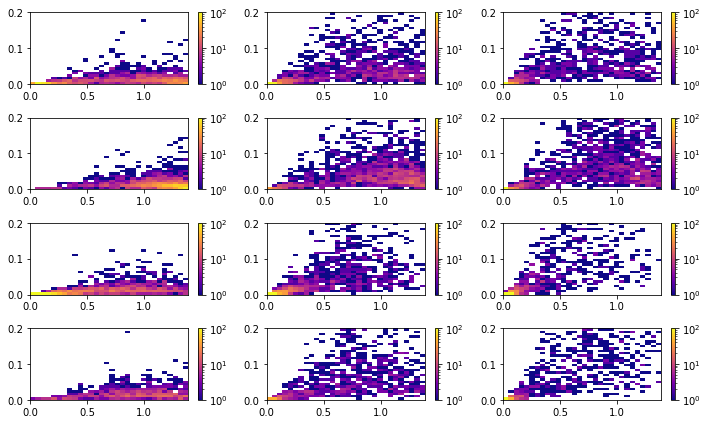

In [29]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Assuming your data is something like this (replace with your actual data)

# Create a figure with subplots
fig, axs = plt.subplots(4, 3, figsize=(10, 6))
classes = 4
x_range = (0, np.log(classes))  
y_range = (0, 0.2)  

xtext = 0.1
ytext = 0.6

# Define the range for the color scale
vmin, vmax = 1, 100  # Example values, adjust as needed

# Create a LogNorm object with your desired scale
log_norm = colors.LogNorm(vmin=vmin, vmax=vmax)




# 2D histogram for Dataset 1
ax = axs[0][0]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[0]
name = names[1]+f"_{epoch}_correct"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=30, cmap='plasma',norm=log_norm, range=[x_range, y_range])
fig.colorbar(image1, ax=ax)
print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")


# 2D histogram for Dataset 1
ax = axs[1][0]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[0]
name = names[1]+f"_{epoch}_wrong"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=30, cmap='plasma',norm=log_norm, range=[x_range, y_range])
fig.colorbar(image1, ax=ax)
print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")

# 2D histogram for Dataset 1
ax = axs[0][1]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[1]
name = names[1]+f"_{epoch}_correct"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=30, cmap='plasma',norm=log_norm, range=[x_range, y_range])
fig.colorbar(image1, ax=ax)
print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")

# 2D histogram for Dataset 1
ax = axs[1][1]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[1]
name = names[1]+f"_{epoch}_wrong"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=30, cmap='plasma',norm=log_norm, range=[x_range, y_range])
fig.colorbar(image1, ax=ax)
print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")

# 2D histogram for Dataset 1
ax = axs[0][2]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[2]
name = names[1]+f"_{epoch}_correct"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=30, cmap='plasma',norm=log_norm, range=[x_range, y_range])
fig.colorbar(image1, ax=ax)
print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")

# 2D histogram for Dataset 1
ax = axs[1][2]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[2]
name = names[1]+f"_{epoch}_wrong"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=30, cmap='plasma',norm=log_norm, range=[x_range, y_range])
fig.colorbar(image1, ax=ax)
print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")

##########################################################################################
# 2D histogram for Dataset 1
ax = axs[2][0]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[0]
name = names[2]+f"_{epoch}_correct"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=30, cmap='plasma',norm=log_norm, range=[x_range, y_range])
fig.colorbar(image1, ax=ax)
print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")

# 2D histogram for Dataset 1
ax = axs[3][0]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[0]
name = names[2]+f"_{epoch}_wrong"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=30, cmap='plasma',norm=log_norm, range=[x_range, y_range])
fig.colorbar(image1, ax=ax)
print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")

# 2D histogram for Dataset 1
ax = axs[2][1]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[1]
name = names[2]+f"_{epoch}_correct"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=30, cmap='plasma',norm=log_norm, range=[x_range, y_range])
fig.colorbar(image1, ax=ax)
print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")

# 2D histogram for Dataset 1
ax = axs[3][1]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[1]
name = names[2]+f"_{epoch}_wrong"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=30, cmap='plasma',norm=log_norm, range=[x_range, y_range])
fig.colorbar(image1, ax=ax)
print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")

# 2D histogram for Dataset 1
ax = axs[2][2]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[2]
name = names[2]+f"_{epoch}_correct"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=30, cmap='plasma',norm=log_norm, range=[x_range, y_range])
fig.colorbar(image1, ax=ax)
      
print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")

# 2D histogram for Dataset 1
ax = axs[3][2]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
epoch = epochs[2]
name = names[2]+f"_{epoch}_wrong"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=30, cmap='plasma',norm=log_norm, range=[x_range, y_range])
fig.colorbar(image1, ax=ax)
print("--------------------------")
print(f"Name: {name}")
print(f"Average Mutual Information at epoch {epoch}:  {np.mean(y1)}")

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Assuming your data is something like this (replace with your actual data)

# Create a figure with subplots
fig, axs = plt.subplots(4, 3, figsize=(9, 9))
classes = 4
x_range = (0, np.log(classes))  
y_range = (0, 0.2)  

xtext = 0.1
ytext = 0.6


# Dataset 1
name = names[0]+"_correct"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()

# Dataset 2
name = names[1]+"_correct"
x2 = entropy_res_dic[name].numpy()
y2 = mutual_info_res_dic[name].numpy()

name = names[2]+"_correct"
x3 = entropy_res_dic[name].numpy()
y3 = mutual_info_res_dic[name].numpy()


# 2D histogram for Dataset 1
ax = axs[0][0]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
name = names[1]+"_correct"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=30, cmap='plasma',norm=colors.LogNorm(), range=[x_range, y_range])
ax.set_ylabel('Mutual Information', fontsize=14)
msg = " Trained: CommonsenseQA \n Evaluated: MMLU STEM \n Predictions: Correct"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=14,
           bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'))
fig.colorbar(image1, ax=ax)

# 2D histogram for Dataset 1
ax = axs[1][0]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
name = names[1]+"_wrong"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=30, cmap='plasma',norm=colors.LogNorm(), range=[x_range, y_range])
ax.set_xlabel('Entropy', fontsize=14)
ax.set_ylabel('Mutual Information', fontsize=14)
msg = " Trained: CommonsenseQA \n Evaluated: MMLU STEM \n Predictions: Wrong"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=14,
           bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'))
fig.colorbar(image1, ax=ax)

# 2D histogram for Dataset 1
ax = axs[0][1]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
name = names[2]+"_correct"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=30, norm=colors.LogNorm(), cmap='plasma', range=[x_range, y_range])
msg = " Trained: CommonsenseQA \n Evaluated: MMLU SS \n Predictions: Correct"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=14,
           bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'))
fig.colorbar(image1, ax=ax)

# 2D histogram for Dataset 1
ax = axs[1][1]
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
name = names[2]+"_wrong"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=30, norm=colors.LogNorm(), cmap='plasma', range=[x_range, y_range])
ax.set_xlabel('Entropy', fontsize=14)
msg = " Trained: CommonsenseQA \n Evaluated: MMLU SS \n Predictions: Wrong"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=14,
           bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'))
fig.colorbar(image1, ax=ax)


# 2D histogram for Dataset 1
ax = axs[0][2]
ax.set_ylim(0, 0.1)
y_range = (0, 0.002) 
ax.set_xlim(0, np.log(classes))
name = names[-1]+"_correct"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=30, norm=colors.LogNorm(), cmap='plasma', range=[x_range, y_range])
ax.set_xlabel('Entropy', fontsize=14)
msg = " Trained: MMLU SS \n Evaluated: MMLU STEM \n Predictions: Correct"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=14,
           bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'))
fig.colorbar(image1, ax=ax)


# 2D histogram for Dataset 1
ax = axs[1][2]
ax.set_ylim(0, 0.002)
y_range = (0, 0.002) 
ax.set_xlim(0, np.log(classes))
name = names[-1]+"_wrong"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=30, norm=colors.LogNorm(), cmap='plasma', range=[x_range, y_range])
ax.set_xlabel('Entropy', fontsize=14)

msg = " Trained: MMLU SS \n Evaluated: MMLU STEM \n Predictions: Wrong"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=14,
           bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'))
fig.colorbar(image1, ax=ax)





# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming your data is something like this (replace with your actual data)

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
x_range = (0, 1.5)  
y_range = (0, 0.2)  


# Dataset 1
name = names[0]+"_wrong"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()

# Dataset 2
name = names[1]+"_wrong"
x2 = entropy_res_dic[name].numpy()
y2 = mutual_info_res_dic[name].numpy()

name = names[2]+"_wrong"
x3 = entropy_res_dic[name].numpy()
y3 = mutual_info_res_dic[name].numpy()


# 2D histogram for Dataset 1
hist1, xedges, yedges, image1 = axs[0].hist2d(x1, y1, bins=30, cmap='plasma', range=[x_range, y_range])
axs[0].set_title('Dataset 1')
axs[0].set_xlabel('Entropy')
axs[0].set_ylabel('Mutual Information')
axs[0].set_ylim(0, 0.1)
axs[0].set_xlim(0, 1.6)
fig.colorbar(image1, ax=axs[0], label='Density')

# 2D histogram for Dataset 2
hist2, xedges, yedges, image2 = axs[1].hist2d(x2, y2, bins=30, cmap='plasma', range=[x_range, y_range])
axs[1].set_title('Dataset 2')
axs[1].set_xlabel('Entropy')
axs[1].set_ylabel('Mutual Information')
axs[1].set_ylim(0, 0.1)
axs[1].set_xlim(0, 1.6)
fig.colorbar(image2, ax=axs[1], label='Density')

hist3, xedges, yedges, image3 = axs[2].hist2d(x3, y3, bins=30, cmap='plasma', range=[x_range, y_range])
axs[2].set_title('Dataset 3')
axs[2].set_xlabel('Entropy')
axs[2].set_ylabel('Mutual Information')
axs[2].set_ylim(0, 0.1)
axs[2].set_xlim(0, 1.6)
fig.colorbar(image2, ax=axs[2], label='Density')

# Show the plot
plt.tight_layout()
plt.show()
